# K最邻近算法与决策树算法实现收入预测

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1、数据集下载

In [1]:
import kagglehub      #确保安装了该库

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████| 652k/652k [00:02<00:00, 298kB/s]

Extracting files...
Path to dataset files: C:\Users\lenovo\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2


# 2、加载并检查数据

In [167]:
#注意替换路径时要保留路径前的r
data = pd.read_csv(r'C:\Users\lenovo\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2\adult.csv') 
data.info() #输出数据集信息
print(data["native-country"]) #输出age特征列
data.tail() #显示数据集的最后几行

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
0        United-States
1        United-States
2        United-States
3      

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


## 3、数据预处理
- 将标题中的“-”符号改为下划线，便于索引，如：capital-gain -> capital_gain；
- 将income列的“<=50K”设置为0,“>50K”设置为1；
- 删除掉与educational-num表达相同特征的education列；
- 对离散数据进行编码然后归一化，连续数据直接进行归一化；

In [168]:
#列标题替换
data.rename(columns={'educational-num': 'educational_num'}, inplace=True)
data.rename(columns={'marital-status': 'marital_status'}, inplace=True)
data.rename(columns={'capital-gain': 'capital_gain'}, inplace=True)
data.rename(columns={'capital-loss': 'capital_loss'}, inplace=True)
data.rename(columns={'hours-per-week': 'hours_per_week'}, inplace=True)
data.rename(columns={'native-country': 'native_country'}, inplace=True)

In [169]:
#替换列
data['income']=data['income'].apply(lambda s:s.strip())
data.loc[data['income']=='>50K','target']=1
data.loc[data['income']=='<=50K','target']=0
data.drop(columns='income',inplace=True)
print(data["target"])

0        0.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
48837    0.0
48838    1.0
48839    0.0
48840    0.0
48841    1.0
Name: target, Length: 48842, dtype: float64


In [170]:
#删除列
data.drop(["education"], axis = 1, inplace = True)

In [171]:
#对离散数据列进行编码后归一化，连续数据列直接进行归一化
continue_columns = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
scatter_columns = ['workclass', 'marital_status','occupation','relationship','race','gender','native_country']
target_columns = 'target'

#定义函数
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings

def preprocess_data(data, continue_columns, scatter_columns):    
    # 创建数据副本，避免修改原始数据
    processed_data = data.copy()
    
    # 检查输入列是否存在于数据集中
    all_columns = set(data.columns)
    continue_columns = [col for col in continue_columns if col in all_columns]
    scatter_columns = [col for col in scatter_columns if col in all_columns]
    
    # 处理离散列（scatter_columns）
    for col in scatter_columns:
        if col in processed_data.columns:
            # 检查列的数据类型
            if processed_data[col].dtype == 'object' or processed_data[col].dtype.name == 'category':
                # 对离散字符列进行标签编码
                le = LabelEncoder()
                processed_data[col] = le.fit_transform(processed_data[col].astype(str))
            
            # 对编码后的列进行最大最小值归一化
            if processed_data[col].nunique() > 1:  # 避免除零错误
                min_val = processed_data[col].min()
                max_val = processed_data[col].max()
                processed_data[col] = (processed_data[col] - min_val) / (max_val - min_val)
            else:
                # 如果所有值都相同，归一化为0
                processed_data[col] = 0.0
                warnings.warn(f"列 '{col}' 所有值相同，归一化为0")
    
    # 处理连续列（continue_columns）
    for col in continue_columns:
        if col in processed_data.columns:
            # 检查是否为数值列
            if pd.api.types.is_numeric_dtype(processed_data[col]):
                if processed_data[col].nunique() > 1:  # 避免除零错误
                    min_val = processed_data[col].min()
                    max_val = processed_data[col].max()
                    processed_data[col] = (processed_data[col] - min_val) / (max_val - min_val)
                else:
                    # 如果所有值都相同，归一化为0
                    processed_data[col] = 0.0
                    warnings.warn(f"列 '{col}' 所有值相同，归一化为0")
            else:
                warnings.warn(f"列 '{col}' 不是数值类型，跳过归一化处理")
    
    return processed_data

In [172]:
#执行函数
processed_data = preprocess_data(data, continue_columns, scatter_columns)
data_y = processed_data.target
data_x = processed_data.drop(["target"],axis = 1)
#只使用部分数据否则模型训练过程很慢
data_y = data_y[0:3000]
data_x = data_x[0:3000]
data_x

,age,workclass,fnlwgt,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
0,0.109589,0.500,0.145129,0.400000,0.666667,0.500000,0.6,0.5,1.0,0.000000,0.0,0.397959,0.95122
1,0.287671,0.500,0.052451,0.533333,0.333333,0.357143,0.0,1.0,1.0,0.000000,0.0,0.500000,0.95122
2,0.150685,0.250,0.219649,0.733333,0.333333,0.785714,0.0,1.0,1.0,0.000000,0.0,0.397959,0.95122
3,0.369863,0.500,0.100153,0.600000,0.333333,0.500000,0.0,0.5,1.0,0.076881,0.0,0.397959,0.95122
4,0.013699,0.000,0.061708,0.600000,0.666667,0.000000,0.6,1.0,0.0,0.000000,0.0,0.295918,0.95122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.068493,0.000,0.032505,0.600000,0.333333,0.000000,0.0,1.0,1.0,0.000000,0.0,0.091837,0.95122
2996,0.575342,0.500,0.108471,0.600000,0.000000,0.857143,0.2,1.0,1.0,0.000000,0.0,0.561224,0.95122
2997,0.260274,0.875,0.108914,0.866667,0.666667,0.714286,0.2,0.5,0.0,0.000000,0.0,0.397959,0.95122
2998,0.109589,0.500,0.027492,0.733333,0.333333,0.857143,0.0,1.0,1.0,0.000000,0.0,0.448980,0.95122


## 4、数据可视化

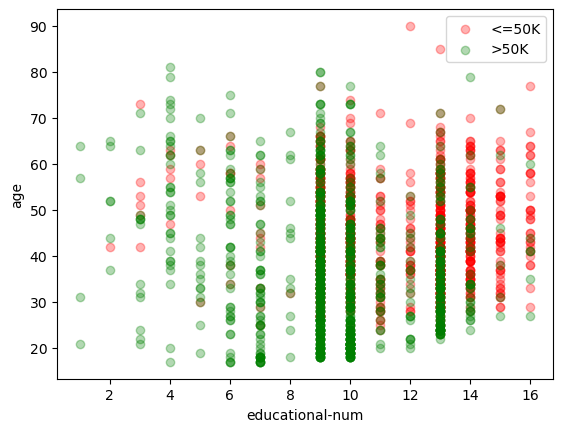

In [173]:
L = data[data.target == 0]
H = data[data.target == 1]

plt.scatter(H.educational_num[0:1000],H.age[0:1000], color = "red", label = "<=50K", alpha = 0.3)
plt.scatter(L.educational_num[0:1000],L.age[0:1000], color = "green", label = ">50K", alpha = 0.3)

plt.xlabel("educational-num")
plt.ylabel("age")

plt.legend()
plt.show()

## 5、划分数据集
划分训练集与数据集，划分比例为7：3

In [174]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.3, random_state=1)

In [175]:
x_train

,age,workclass,fnlwgt,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
1045,0.410959,0.50,0.028398,0.666667,0.333333,0.285714,0.0,1.00,1.0,0.0,0.433196,0.602041,0.951220
2717,0.589041,0.25,0.082864,0.600000,0.333333,0.785714,0.0,1.00,1.0,0.0,0.000000,0.397959,0.951220
2835,0.287671,0.50,0.200602,0.533333,0.000000,0.857143,0.8,1.00,0.0,0.0,0.000000,0.397959,0.951220
2913,0.520548,0.50,0.152318,0.600000,0.000000,0.285714,0.2,1.00,1.0,0.0,0.345271,0.397959,0.951220
959,0.575342,0.50,0.065815,0.533333,0.333333,1.000000,0.0,1.00,1.0,0.0,0.000000,0.551020,0.951220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,0.493151,0.50,0.275091,0.533333,0.333333,0.214286,0.0,0.75,1.0,0.0,0.000000,0.397959,0.634146
905,0.328767,0.50,0.088480,1.000000,0.333333,0.714286,0.0,1.00,1.0,0.0,0.000000,0.602041,0.951220
1096,0.246575,0.50,0.256849,0.600000,0.333333,0.285714,0.0,1.00,1.0,0.0,0.000000,0.397959,0.951220
235,0.232877,0.50,0.091285,0.666667,0.000000,0.928571,0.8,1.00,0.0,0.0,0.000000,0.602041,0.951220


In [176]:
y_train

1045    1.0
2717    0.0
2835    0.0
2913    0.0
959     0.0
       ... 
2763    0.0
905     0.0
1096    0.0
235     0.0
1061    0.0
Name: target, Length: 2100, dtype: float64

## 6、寻找K值

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

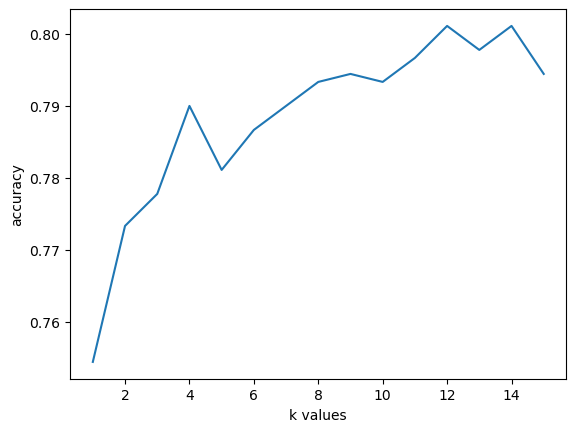

In [177]:
from sklearn.neighbors import KNeighborsClassifier
Score_list = []

for each in range(1, 16):
    knn2 = KNeighborsClassifier(n_neighbors = each)
    knn2.fit(x_train,y_train)
    Score_list.append(knn2.score(x_test,y_test))
    
plt.plot(range(1, 16),Score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

## 7、训练KNN模型并测试模型效果
- 使用KNN库函数实现模型训练，作为参考
- KNN具体算法实现模型训练

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Accuracy Score
3 nn Acc Score 0.7777777777777778 


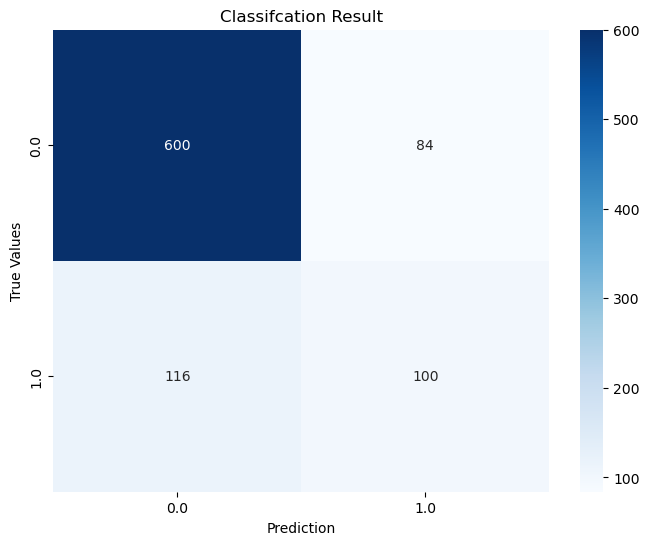

In [178]:
#使用库函数训练模型作为参考
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print("Accuracy Score")
print("{} nn Acc Score {} ".format(3,knn.score(x_test,y_test)))
#seaborntable
cm = confusion_matrix(y_test, prediction.reshape(-1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Prediction')
plt.ylabel('True Values')
plt.title('Classifcation Result')
correct_predictions = np.trace(cm)
total_predictions = np.sum(cm)
incorrect_predictions = total_predictions - correct_predictions
plt.show()

In [179]:
#KNN具体算法实现模型训练
import itertools

class KNN:
    def __init__(self, k=10):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    #训练KNN模型（实际上只是存储训练数据）
    def fit(self, X_train, y_train):
        # 处理特征数据
        if isinstance(X_train, pd.DataFrame):
            if X_train.shape[1] > 1:
                self.X_train = X_train.iloc[:, 1:].values  # 移除第一列序号
            else:
                self.X_train = X_train.values
        else:
            self.X_train = X_train
            
        # 处理标签数据
        if isinstance(y_train, pd.DataFrame):
            if y_train.shape[1] > 1:
                self.y_train = y_train.iloc[:, 1].values
            else:
                self.y_train = y_train.iloc[:, 0].values
        elif isinstance(y_train, pd.Series):
            self.y_train = y_train.values
        else:
            self.y_train = y_train
    #计算欧几里得距离
    def euclidean_distance(self, point1, point2):    
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    #预测单个测试样本
    def predict_single(self, test_point):
        distances = []
        
        # 计算测试点到所有训练点的距离
        for i, train_point in enumerate(self.X_train):
            dist = self.euclidean_distance(test_point, train_point)
            distances.append((dist, self.y_train[i]))
        
        # 按距离排序，取前k个
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]
        
        # 统计k个最近邻的类别
        class_votes = {}
        for dist, label in k_nearest:
            if label in class_votes:
                class_votes[label] += 1
            else:
                class_votes[label] = 1
        
        # 返回票数最多的类别
        return max(class_votes.items(), key=lambda x: x[1])[0]
    
    #预测测试集
    def predict(self, X_test):
        # 处理测试数据
        if isinstance(X_test, pd.DataFrame):
            if X_test.shape[1] > 1:
                X_test_clean = X_test.iloc[:, 1:].values  # 移除第一列序号
            else:
                X_test_clean = X_test.values
        else:
            X_test_clean = X_test
        
        predictions = []
        for test_point in X_test_clean:
            pred = self.predict_single(test_point)
            predictions.append(pred)
        
        return np.array(predictions)
    
    #计算准确度
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)

#绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred):
    classes = sorted(set(y_true) | set(y_pred))
    
    # 创建混淆矩阵
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    # 映射类别到索引
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # 填充混淆矩阵
    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_idx[true]
        pred_idx = class_to_idx[pred]
        cm[true_idx][pred_idx] += 1
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # 在格子中显示数字
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(n_classes), range(n_classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm

模型测试集准确度: 0.8000


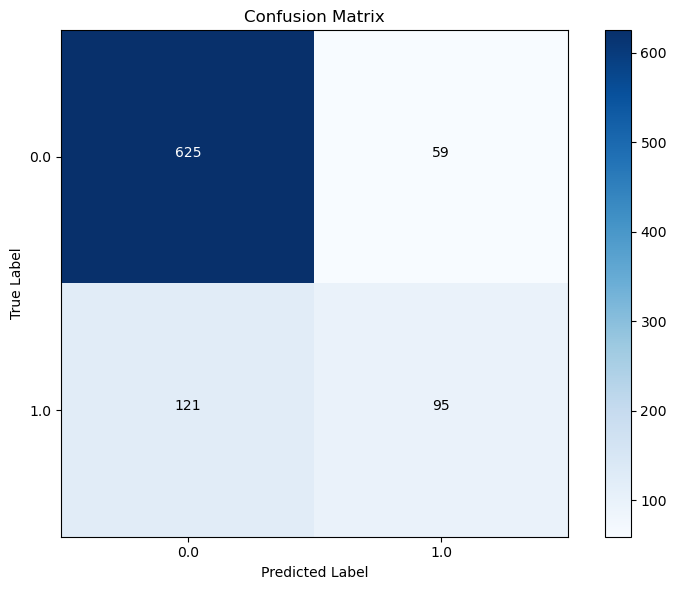

array([[625,  59],
       [121,  95]])

In [180]:
#训练KNN模型并输出结果

# 创建KNN模型
knn = KNN(k=10)

# 训练模型
knn.fit(x_train, y_train)

# 预测测试集
y_pred = knn.predict(x_test)

# 获取真实标签
if isinstance(y_test, pd.DataFrame):
    if y_test.shape[1] > 1:
        y_true = y_test.iloc[:, 1].values
    else:
        y_true = y_test.iloc[:, 0].values
elif isinstance(y_test, pd.Series):
    y_true = y_test.values
else:
    y_true = y_test

# 计算准确度
acc = knn.accuracy(y_true, y_pred)
print(f"模型测试集准确度: {acc:.4f}")

# 绘制混淆矩阵
plot_confusion_matrix(y_true, y_pred)


## 8、训练决策树模型并测试模型效果

In [181]:
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        
    # 训练决策树模型
    def fit(self, X, y):
        # 处理特征数据
        if isinstance(X, pd.DataFrame):
            if X.shape[1] > 1:
                self.feature_names = X.columns[1:].tolist() if hasattr(X, 'columns') else None
                X_clean = X.iloc[:, 1:].values  # 移除第一列序号
            else:
                self.feature_names = None
                X_clean = X.values
        else:
            self.feature_names = None
            X_clean = X
            
        # 处理标签数据
        if isinstance(y, pd.DataFrame):
            if y.shape[1] > 1:
                y_clean = y.iloc[:, 1].values
            else:
                y_clean = y.iloc[:, 0].values
        elif isinstance(y, pd.Series):
            y_clean = y.values
        else:
            y_clean = y
            
        # 构建决策树
        self.tree = self._build_tree(X_clean, y_clean)
    
    # 递归构建决策树
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # 停止条件
        if (depth >= self.max_depth or 
            n_classes == 1 or 
            n_samples < self.min_samples_split):
            return self._create_leaf_node(y)
        
        # 寻找最佳分割
        best_split = self._find_best_split(X, y, n_features)
        
        # 如果没有找到有效的分割，创建叶节点
        if not best_split:
            return self._create_leaf_node(y)
        
        # 递归构建左右子树
        left_indices = best_split['left_indices']
        right_indices = best_split['right_indices']
        
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }
    
    
    # 寻找最佳分割点
    def _find_best_split(self, X, y, n_features):
        best_gini = float('inf')
        best_split = None
        
        # 随机选择特征子集（可选，用于模拟随机森林）
        feature_indices = np.random.choice(n_features, n_features, replace=False)
        
        for feature_index in feature_indices:
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)
            
            # 尝试每个可能的分割点
            for threshold in unique_values:
                # 根据阈值分割数据
                left_indices = np.where(feature_values <= threshold)[0]
                right_indices = np.where(feature_values > threshold)[0]
                
                # 如果分割后任一侧没有样本，跳过
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                
                # 计算基尼指数
                gini = self._gini_index(y, left_indices, right_indices)
                
                # 更新最佳分割
                if gini < best_gini:
                    best_gini = gini
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'gini': gini
                    }
        
        return best_split
    
    #计算基尼指数
    def _gini_index(self, y, left_indices, right_indices):
        n = len(y)
        n_left, n_right = len(left_indices), len(right_indices)
        
        if n_left == 0 or n_right == 0:
            return float('inf')
        
        # 计算左右子集的基尼不纯度
        gini_left = 1.0 - sum([(np.sum(y[left_indices] == c) / n_left) ** 2 
                              for c in np.unique(y)])
        gini_right = 1.0 - sum([(np.sum(y[right_indices] == c) / n_right) ** 2 
                               for c in np.unique(y)])
        
        # 计算加权基尼指数
        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right
        
        return weighted_gini
    
    #创建叶节点
    def _create_leaf_node(self, y):
        counts = Counter(y)
        majority_class = max(counts.items(), key=lambda x: x[1])[0]
        return {'class': majority_class, 'counts': counts}
    
    #预测单个样本
    def predict_single(self, x, node=None):
        if node is None:
            node = self.tree
        
        # 如果是叶节点，返回预测类别
        if 'class' in node:
            return node['class']
        
        # 根据特征值决定走向左子树还是右子树
        if x[node['feature_index']] <= node['threshold']:
            return self.predict_single(x, node['left'])
        else:
            return self.predict_single(x, node['right'])
        
    # 预测测试集
    def predict(self, X):
        # 处理测试数据
        if isinstance(X, pd.DataFrame):
            if X.shape[1] > 1:
                X_clean = X.iloc[:, 1:].values  # 移除第一列序号
            else:
                X_clean = X.values
        else:
            X_clean = X
        
        predictions = []
        for sample in X_clean:
            pred = self.predict_single(sample)
            predictions.append(pred)
        
        return np.array(predictions)
    
    #计算准确度
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)
    
#绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred):
    classes = sorted(set(y_true) | set(y_pred))
    
    # 创建混淆矩阵
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    # 映射类别到索引
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # 填充混淆矩阵
    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_idx[true]
        pred_idx = class_to_idx[pred]
        cm[true_idx][pred_idx] += 1
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Decision Tree - Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # 在格子中显示数字
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(n_classes), range(n_classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm

决策树模型测试集准确度: 0.8322


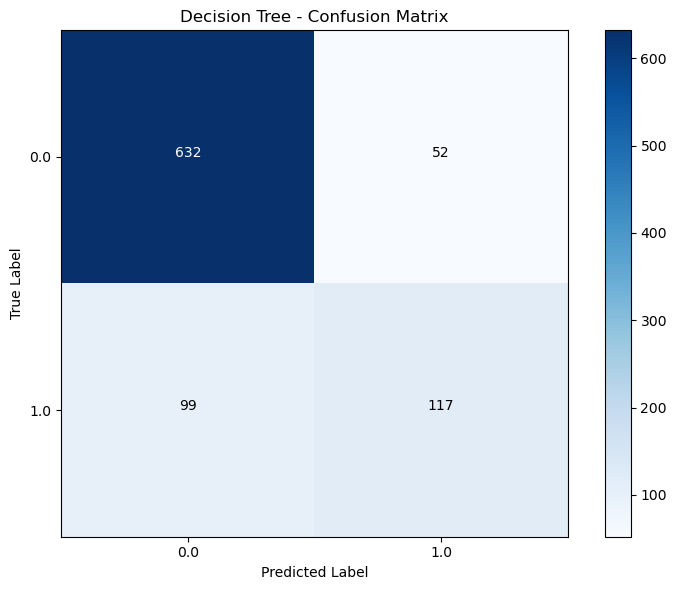

In [182]:
#执行函数
decision_tree_model(x_train, x_test, y_train, y_test, max_depth=10, min_samples_split=5)